In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
import paths as pth
import crosswalk as cwlk
import mrtool
import crosswalk_functions

In [3]:
param_estimate_df = pd.DataFrame({'draw': np.arange(1000)})
param_summary_df = pd.DataFrame({v: [] for v in ['beta', 'se_beta']},
                                index=[])

In [ ]:
df = pd.read_csv(pth.PAIRED_CWALK_DF)


In [7]:
df.loc[(df['log_icer_sens'].notnull()) & (~np.isinf(df['log_icer_sens'])) &\
       (df['log_icer_ref'].notnull()) & (~np.isinf(df['log_icer_ref'])) &\
       (df['log_icer_se_ref'].notnull()),
       'sens_vars'
      ].value_counts()

vaccine_total_cost     427
efficacy               285
vaccine_type           281
ReaderPerspectiveID    189
DiscountRate            55
coverage                14
CostsDiscountRate       12
Name: sens_vars, dtype: int64

In [8]:
df = df.loc[df['sens_vars'].notnull()]

# Vaccine Cost

In [9]:
df.filter(regex='vac')

,vaccine_total_cost_sens,vaccine_cost_sens,log_vacc_cost_sens,vaccine_describe_sens,vaccine_total_cost_ref,vaccine_cost_ref,log_vacc_cost_ref,vaccine_describe_ref
0,25.0,33.155425,3.501206,course,10.0,13.262170,2.584916,course
1,4.5,5.967977,1.786408,dose,15.0,19.893255,2.990381,dose
2,4.5,9.474803,2.248636,dose,15.0,31.582675,3.452609,dose
3,4.5,6.535810,1.877296,dose,15.0,21.786033,3.081269,dose
4,4.5,6.290750,1.839080,dose,15.0,20.969165,3.043053,dose
...,...,...,...,...,...,...,...,...
1375,4.5,9.170745,2.216018,dose,4.5,9.170745,2.216018,dose
1376,4.5,4.485196,1.500782,dose,4.5,4.485196,1.500782,dose
1377,4.5,4.122424,1.416441,dose,4.5,4.122424,1.416441,dose
1378,4.5,5.094298,1.628122,dose,4.5,5.094298,1.628122,dose


In [10]:
vacc_cost_df = df[df['sens_vars'].isin(['vaccine_total_cost'])].copy()

non_na_cols = ['log_icer_sens', 'log_icer_ref', 'log_vacc_cost_sens', 'log_vacc_cost_ref']
vacc_cost_df = vacc_cost_df.loc[vacc_cost_df[non_na_cols].notnull().all(axis=1)].copy()
vacc_cost_df = vacc_cost_df.loc[~np.isinf(vacc_cost_df[non_na_cols]).any(axis=1)].copy()

In [11]:
vacc_cost_df = crosswalk_functions.create_diff_variables(
    vacc_cost_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='log_vacc_cost')

In [12]:
cwalk_rids = set(list(vacc_cost_df['RatioID'].unique()) + list(vacc_cost_df['reference_scenario']))

In [15]:
vacc_cost_df.loc[(vacc_cost_df['vaccine_describe_ref'] != vacc_cost_df['vaccine_describe_sens']) &\
                 (~vacc_cost_df['vaccine_describe_ref'].isnull()) & (~vacc_cost_df['vaccine_describe_sens'].isnull()),
                 ['RatioID', 'reference_scenario', 'vaccine_describe_ref', 'vaccine_describe_sens']]

,RatioID,reference_scenario,vaccine_describe_ref,vaccine_describe_sens


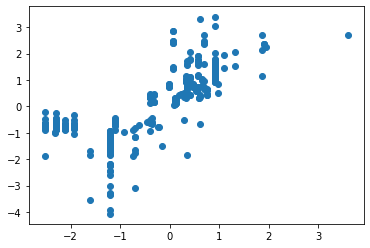

In [16]:
plt.scatter(x=vacc_cost_df['log_vacc_cost_diff'].to_numpy(),
            y=vacc_cost_df['log_icer_diff'].to_numpy(),
           )

In [17]:
vacc_cost_df['clr'] = (vacc_cost_df['log_icer_diff'].between(-1.2, 0)) & (vacc_cost_df['log_vacc_cost_diff'] < -1.7)

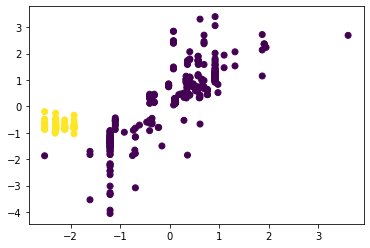

In [18]:
plt.scatter(x=vacc_cost_df['log_vacc_cost_diff'].to_numpy(),
            y=vacc_cost_df['log_icer_diff'].to_numpy(),
            c=vacc_cost_df['clr'].to_numpy()
           )

In [21]:
vacc_cost_df = vacc_cost_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [22]:
vacc_cost_df = vacc_cost_df.loc[vacc_cost_df['log_icer_diff'].notnull()]

In [23]:
mr = crosswalk_functions.cwalk(vacc_cost_df, 'log_icer', 'log_icer_se', 'log_vacc_cost', 'ArticleID')

In [24]:
mr.beta_soln

array([0.       , 0.7327554])

In [25]:
vacc_cost_beta_samples, vacc_cost_summary = crosswalk_functions.summarize_cwalk(mr, 'log_vacc_cost')

In [26]:
vacc_cost_summary

,beta,se_beta,sample_size
log_vacc_cost,0.732755,0.014686,427


In [27]:
crosswalk_functions.compare_sd_versions(mr, beta_samples=vacc_cost_beta_samples)

/ihme/homes/zhengp/Repositories/MRTool.git/src/mrtool/core/other_sampling.py:83: UserWarning: Model is not a simple mixed effects model. Uncertainty might not be accurate.
  warn("Model is not a simple mixed effects model. Uncertainty might not be accurate.")


{'Fisher Information': 0.01411643108065596, 'Fit-Refit': 0.014686066046193736}

In [28]:
param_estimate_df['log_vaccine_cost'] = vacc_cost_beta_samples

In [29]:
param_summary_df = pd.concat([param_summary_df,
                              vacc_cost_summary],
                             axis=0)

In [30]:
param_summary_df

,beta,se_beta,sample_size
log_vacc_cost,0.732755,0.014686,427.0


# Q/DALYs Discount Rate

In [31]:
bdr_df = df[df['sens_vars'] == 'DiscountRate'].copy()
bdr_df = bdr_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)
# bdr_df = bdr_df.rename(
#     {'value' + i: 'burden_disc_rate' + i for i in ['_sens', '_ref']},
#     axis=1)
bdr_df[['log_icer_sens', 'log_icer_ref', 'log_icer_se_sens', 'burden_disc_rate_sens',
        'log_icer_se_ref', 'burden_disc_rate_ref', 'ArticleID']].isnull().sum(axis=1).sum()

4

In [32]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'burden_disc_rate_sens', 'burden_disc_rate_ref']
bdr_df = bdr_df.loc[bdr_df[non_na_cols].notnull().all(axis=1)].copy()
bdr_df = bdr_df.loc[~np.isinf(bdr_df[non_na_cols]).any(axis=1)].copy()

In [33]:
bdr_df = crosswalk_functions.create_diff_variables(
    bdr_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='burden_disc_rate')

In [34]:
bdr_df

,RatioID,PubMedID_sens,sens_vars,reference_scenario,year_id_sens,lancet_label_sens,location_id_sens,region_name_sens,super_region_name_sens,log_GDP_per_cap_sens,...,efficacy_desc_ref,coverage_ref,ltd_and_societal_ref,payer_ref,ltd_societal_ref,sector_ref,not_lifetime_ref,log_icer_diff,log_icer_se_diff,burden_disc_rate_diff
230,2012-01-10419-D,23730312,DiscountRate,2012-01-10419-03,2009,canada,101,High-income North America,High-income,10.559744,...,hospitalization,94.0,0,1,0,0,1,-0.243484,0.353553,-5.0
231,2012-01-10419-C,23730312,DiscountRate,2012-01-10419-01,2009,canada,101,High-income North America,High-income,10.559744,...,hospitalization,94.0,0,1,0,0,1,-0.179128,0.353553,-5.0
233,2012-01-10419-B,23730312,DiscountRate,2012-01-10419-03,2009,canada,101,High-income North America,High-income,10.559744,...,hospitalization,94.0,0,1,0,0,1,-0.243484,0.353553,-2.0
234,2012-01-10419-A,23730312,DiscountRate,2012-01-10419-01,2009,canada,101,High-income North America,High-income,10.559744,...,hospitalization,94.0,0,1,0,0,1,-0.179128,0.353553,-2.0
334,2008-01-04407-P,18948433,DiscountRate,2008-01-04407-D,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,1,0,0,0,1,-0.256311,0.353553,-5.0
335,2008-01-04407-P,18948433,DiscountRate,2008-01-04407-D,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,1,0,0,0,1,-0.256311,0.353553,-5.0
344,2008-01-04407-Q,18948433,DiscountRate,2008-01-04407-01,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,0,1,0,0,1,-0.092359,0.353553,-1.5
351,2008-01-04407-S,18948433,DiscountRate,2008-01-04407-04,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,1,0,0,0,1,-0.491684,0.353553,-1.5
355,2008-01-04407-T,18948433,DiscountRate,2008-01-04407-03,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,1,0,0,0,1,-0.160068,0.353553,-1.5
356,2008-01-04407-T,18948433,DiscountRate,2008-01-04407-03,2006,belgium,76,Western Europe,High-income,10.544776,...,death,97.5,1,0,0,0,1,-0.160068,0.353553,-1.5


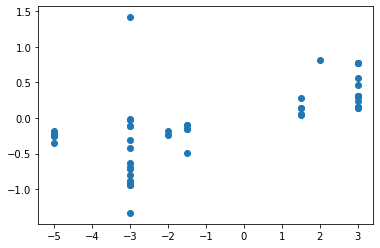

In [35]:
plt.scatter(x=bdr_df['burden_disc_rate_diff'].to_numpy(),
            y=bdr_df['log_icer_diff'].to_numpy(),
           )

In [36]:
bdr_mr = crosswalk_functions.cwalk(bdr_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='burden_disc_rate', study_id='ArticleID')

In [37]:
bdr_mr.beta_soln

array([0.       , 0.1174978])

In [38]:
bdr_mr.data.obs.shape

(55,)

In [39]:
bdr_beta_samples, bdr_summary = crosswalk_functions.summarize_cwalk(bdr_mr, 'burden_disc_rate')

In [40]:
crosswalk_functions.compare_sd_versions(bdr_mr, beta_samples=bdr_beta_samples)

/ihme/homes/zhengp/Repositories/MRTool.git/src/mrtool/core/other_sampling.py:83: UserWarning: Model is not a simple mixed effects model. Uncertainty might not be accurate.
  warn("Model is not a simple mixed effects model. Uncertainty might not be accurate.")


{'Fisher Information': 0.01543768802736096, 'Fit-Refit': 0.015669909999644266}

In [41]:
param_estimate_df['burden_disc_rate'] = bdr_beta_samples

In [42]:
param_summary_df = pd.concat([param_summary_df,
                              bdr_summary],
                             axis=0)

In [43]:
param_summary_df

,beta,se_beta,sample_size
log_vacc_cost,0.732755,0.014686,427.0
burden_disc_rate,0.117498,0.015670,55.0


# Cost discount rate

In [44]:
cdr_df = df.loc[df['sens_vars'].isin(['CostDiscountRate', 'CostsDiscountRate'])].copy()

In [45]:
cdr_df

,RatioID,ArticleID_sens,PubMedID_sens,sens_vars,reference_scenario,year_id_sens,lancet_label_sens,location_id_sens,region_name_sens,super_region_name_sens,...,log_vacc_cost_ref,vaccine_describe_ref,efficacy_ref,efficacy_desc_ref,coverage_ref,ltd_and_societal_ref,payer_ref,ltd_societal_ref,sector_ref,not_lifetime_ref
333,2008-01-04407-O,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-W,2006,belgium,76,Western Europe,High-income,...,5.009154,dose,96.0,death,97.5,1,0,0,0,1
342,2008-01-04407-P,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,1,0,0,0,1
343,2008-01-04407-P,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,1,0,0,0,1
347,2008-01-04407-Q,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-U,2006,belgium,76,Western Europe,High-income,...,5.009154,dose,96.0,death,97.5,0,1,0,0,1
350,2008-01-04407-R,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-V,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,0,1,0,0,1
354,2008-01-04407-S,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-W,2006,belgium,76,Western Europe,High-income,...,5.009154,dose,96.0,death,97.5,1,0,0,0,1
375,2008-01-04407-N,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-V,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,0,1,0,0,1
390,2008-01-04407-M,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-U,2006,belgium,76,Western Europe,High-income,...,5.009154,dose,96.0,death,97.5,0,1,0,0,1
410,2008-01-04407-T,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,1,0,0,0,1
411,2008-01-04407-T,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,5.000185,dose,98.0,death,97.5,1,0,0,0,1


In [46]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'cost_disc_rate_sens', 'cost_disc_rate_ref']
cdr_df = cdr_df.loc[cdr_df[non_na_cols].notnull().all(axis=1)].copy()
cdr_df = cdr_df.loc[~np.isinf(cdr_df[non_na_cols]).any(axis=1)].copy()

In [47]:
cdr_df = crosswalk_functions.create_diff_variables(
    cdr_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='cost_disc_rate')

In [48]:
cdr_df

,RatioID,ArticleID_sens,PubMedID_sens,sens_vars,reference_scenario,year_id_sens,lancet_label_sens,location_id_sens,region_name_sens,super_region_name_sens,...,efficacy_desc_ref,coverage_ref,ltd_and_societal_ref,payer_ref,ltd_societal_ref,sector_ref,not_lifetime_ref,log_icer_diff,log_icer_se_diff,cost_disc_rate_diff
333,2008-01-04407-O,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-W,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.738953,0.353553,5.0
342,2008-01-04407-P,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.288744,0.353553,5.0
343,2008-01-04407-P,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.288744,0.353553,5.0
347,2008-01-04407-Q,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-U,2006,belgium,76,Western Europe,High-income,...,death,97.5,0,1,0,0,1,0.020607,0.353553,3.0
350,2008-01-04407-R,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-V,2006,belgium,76,Western Europe,High-income,...,death,97.5,0,1,0,0,1,0.008264,0.353553,3.0
354,2008-01-04407-S,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-W,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.081862,0.353553,3.0
375,2008-01-04407-N,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-V,2006,belgium,76,Western Europe,High-income,...,death,97.5,0,1,0,0,1,0.014957,0.353553,5.0
390,2008-01-04407-M,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-U,2006,belgium,76,Western Europe,High-income,...,death,97.5,0,1,0,0,1,0.024126,0.353553,5.0
410,2008-01-04407-T,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.141662,0.353553,3.0
411,2008-01-04407-T,2008-01-04407,18948433,CostsDiscountRate,2008-01-04407-X,2006,belgium,76,Western Europe,High-income,...,death,97.5,1,0,0,0,1,0.141662,0.353553,3.0


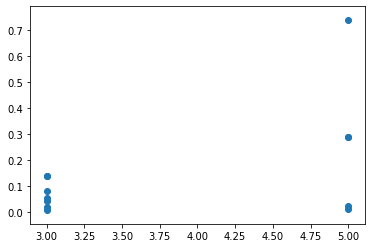

In [49]:
plt.scatter(x=cdr_df['cost_disc_rate_diff'].to_numpy(),
            y=cdr_df['log_icer_diff'].to_numpy(),
           )

In [50]:
cdr_df.loc[cdr_df['cost_disc_rate_diff'] == 0, 'RatioID'].unique()

array([], dtype=object)

In [51]:
cdr_df = cdr_df.drop('ArticleID_ref', axis=1).rename({'ArticleID_sens': 'ArticleID'}, axis=1)

In [52]:
cdr_mr = crosswalk_functions.cwalk(cdr_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='cost_disc_rate', study_id='ArticleID')

In [53]:
cdr_mr.beta_soln

array([0.        , 0.04391626])

In [54]:
cdr_beta_samples, cdr_summary = crosswalk_functions.summarize_cwalk(cdr_mr, 'cost_disc_rate')

In [55]:
crosswalk_functions.compare_sd_versions(cdr_mr, beta_samples=cdr_beta_samples)

/ihme/homes/zhengp/Repositories/MRTool.git/src/mrtool/core/other_sampling.py:83: UserWarning: Model is not a simple mixed effects model. Uncertainty might not be accurate.
  warn("Model is not a simple mixed effects model. Uncertainty might not be accurate.")


{'Fisher Information': 0.025785531156469855, 'Fit-Refit': 0.02673224403487446}

In [56]:
param_estimate_df['cost_disc_rate'] = cdr_beta_samples

In [57]:
param_summary_df = pd.concat([param_summary_df,
                              cdr_summary],
                             axis=0)

In [58]:
param_summary_df

,beta,se_beta,sample_size
log_vacc_cost,0.732755,0.014686,427.0
burden_disc_rate,0.117498,0.015670,55.0
cost_disc_rate,0.043916,0.026732,12.0


## Coverage

In [59]:
cvg_df = df[df['sens_vars'] == 'coverage'].copy()

In [60]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'coverage_sens', 'coverage_ref']
cvg_df = cvg_df.loc[cvg_df[non_na_cols].notnull().all(axis=1)].copy()
cvg_df = cvg_df.loc[~np.isinf(cvg_df[non_na_cols]).any(axis=1)].copy()

In [61]:
cvg_df = crosswalk_functions.create_diff_variables(
    cvg_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='coverage')

In [62]:
cvg_df

,RatioID,ArticleID_sens,PubMedID_sens,sens_vars,reference_scenario,year_id_sens,lancet_label_sens,location_id_sens,region_name_sens,super_region_name_sens,...,efficacy_desc_ref,coverage_ref,ltd_and_societal_ref,payer_ref,ltd_societal_ref,sector_ref,not_lifetime_ref,log_icer_diff,log_icer_se_diff,coverage_diff
458,2008-01-02895-G,2008-01-02895,18166250,coverage,2008-01-02895-01,2005,france,80,Western Europe,High-income,...,severe,75.0,0,1,0,0,1,-0.000022,0.353553,-25.0
459,2008-01-02895-H,2008-01-02895,18166250,coverage,2008-01-02895-01,2005,france,80,Western Europe,High-income,...,severe,75.0,0,1,0,0,1,-0.000022,0.353553,20.0
866,2011-01-01388-D,2011-01-01388,21288839,coverage,2011-01-01388-01,2008,india,163,South Asia,South Asia,...,death,63.0,0,1,0,0,1,-0.002806,0.353553,-10.0
874,2011-01-01388-E,2011-01-01388,21288839,coverage,2011-01-01388-01,2008,india,163,South Asia,South Asia,...,death,63.0,0,1,0,0,1,0.002333,0.353553,10.0
962,2012-01-01093-P,2012-01-01093,22705174,coverage,2012-01-01093-C,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000277,0.353553,7.0
973,2012-01-01093-O,2012-01-01093,22705174,coverage,2012-01-01093-B,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000000,0.353553,7.0
974,2012-01-01093-N,2012-01-01093,22705174,coverage,2012-01-01093-D,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000000,0.353553,-10.0
975,2012-01-01093-M,2012-01-01093,22705174,coverage,2012-01-01093-C,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000000,0.353553,-10.0
976,2012-01-01093-L,2012-01-01093,22705174,coverage,2012-01-01093-B,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000000,0.353553,-10.0
988,2012-01-01093-Q,2012-01-01093,22705174,coverage,2012-01-01093-D,2007,china,6,East Asia,"Southeast Asia, East Asia, and Oceania",...,death,93.0,1,0,0,0,0,0.000266,0.353553,7.0


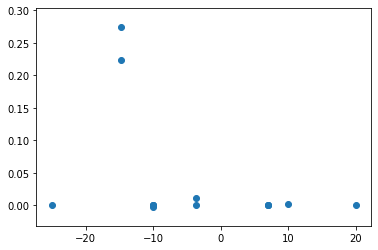

In [63]:
plt.scatter(x=cvg_df['coverage_diff'].to_numpy(),
            y=cvg_df['log_icer_diff'].to_numpy(),
           )

In [64]:
cvg_df = cvg_df.drop('ArticleID_ref', axis=1).rename({'ArticleID_sens': 'ArticleID'}, axis=1)

In [65]:
cvg_df[['log_icer_diff', 'log_icer_se_diff', 'coverage_diff', 'ArticleID']].isnull().sum(axis=1).sum()

0

In [67]:
cvg_df[['log_icer_diff', 'log_icer_se_diff', 'coverage_diff', 'ArticleID']]

,log_icer_diff,log_icer_se_diff,coverage_diff,ArticleID
458,-0.000022,0.353553,-25.0,2008-01-02895
459,-0.000022,0.353553,20.0,2008-01-02895
866,-0.002806,0.353553,-10.0,2011-01-01388
874,0.002333,0.353553,10.0,2011-01-01388
962,0.000277,0.353553,7.0,2012-01-01093
973,0.000000,0.353553,7.0,2012-01-01093
974,0.000000,0.353553,-10.0,2012-01-01093
975,0.000000,0.353553,-10.0,2012-01-01093
976,0.000000,0.353553,-10.0,2012-01-01093
988,0.000266,0.353553,7.0,2012-01-01093


In [68]:
cvg_mr = crosswalk_functions.cwalk(cvg_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='coverage', study_id='ArticleID')

In [69]:
cvg_mr.beta_soln

array([ 0.        , -0.00342053])

In [68]:
cvg_mr.data.obs.shape

(14,)

In [69]:
coverage_beta_samples, coverage_summary = crosswalk_functions.summarize_cwalk(cvg_mr, 'coverage')

In [70]:
coverage_summary

,beta,se_beta,sample_size
coverage,0.0,0.004462,14


In [71]:
crosswalk_functions.compare_sd_versions(cvg_mr, beta_samples=coverage_beta_samples)

/ihme/homes/zhengp/Repositories/MRTool.git/src/mrtool/core/other_sampling.py:83: UserWarning: Model is not a simple mixed effects model. Uncertainty might not be accurate.
  warn("Model is not a simple mixed effects model. Uncertainty might not be accurate.")


{'Fisher Information': 0.007657838897187523,
 'Fit-Refit': 0.0044619977198341815}

In [72]:
param_estimate_df['coverage'] = coverage_beta_samples

In [73]:
param_summary_df = pd.concat([param_summary_df,
                              coverage_summary],
                             axis=0)

# Vaccine type

In [74]:
vacc_type_df = df.loc[df['sens_vars'] == 'vaccine_type'].copy()
vacc_type_df = vacc_type_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [75]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'pentavalent_sens', 'pentavalent_ref']
vacc_type_df = vacc_type_df.loc[vacc_type_df[non_na_cols].notnull().all(axis=1)].copy()
vacc_type_df = vacc_type_df.loc[~np.isinf(vacc_type_df[non_na_cols]).any(axis=1)].copy()

In [76]:
vacc_type_df = vacc_type_df[vacc_type_df['pentavalent_sens'] != vacc_type_df['pentavalent_ref']].copy()

In [77]:
vacc_type_df.shape

(281, 80)

In [78]:
vacc_type_df = crosswalk_functions.create_diff_variables(
    vacc_type_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='pentavalent')
vacc_type_df = vacc_type_df[(vacc_type_df['log_icer_diff'].notnull()) & (vacc_type_df['log_icer_diff'] != 0)]

In [79]:
vacc_type_mr = crosswalk_functions.cwalk(vacc_type_df, resp_name='log_icer', se_name='log_icer_se',
                                         cov_name='pentavalent', study_id='ArticleID')

In [80]:
vacc_type_mr.beta_soln

array([0.        , 0.31652141])

In [81]:
vacc_type_beta_samples, vacc_type_summary = crosswalk_functions.summarize_cwalk(vacc_type_mr, 'pentavalent')

In [82]:
crosswalk_functions.compare_sd_versions(vacc_type_mr, beta_samples=vacc_type_beta_samples)

{'Fisher Information': 0.021091227030479897, 'Fit-Refit': 0.020489834709853764}

In [83]:
param_estimate_df['pentavalent'] = vacc_type_beta_samples

In [84]:
param_summary_df = pd.concat([param_summary_df,
                              vacc_type_summary],
                             axis=0)

# Perspective

In [85]:
persp_df = df.loc[df['sens_vars'] == 'ReaderPerspectiveID'].copy()
persp_df = persp_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)

In [86]:
non_na_cols = ['log_icer_sens', 'log_icer_ref']
non_na_cols = non_na_cols + [i + j for i in ['payer', 'sector', 'ltd_societal', 'ltd_and_societal'] for j in  ['_sens', '_ref']]
persp_df = persp_df.loc[persp_df[non_na_cols].notnull().all(axis=1)].copy()
persp_df = persp_df.loc[~np.isinf(persp_df[non_na_cols]).any(axis=1)].copy()

In [87]:
persp_df = crosswalk_functions.create_diff_variables(
    persp_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='payer')
persp_df = crosswalk_functions.create_diff_variables(
    persp_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='ltd_societal')
persp_df = crosswalk_functions.create_diff_variables(
    persp_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='sector')
persp_df = crosswalk_functions.create_diff_variables(
    persp_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='ltd_and_societal')

In [88]:
persp_df = persp_df[(persp_df['log_icer_diff'].notnull()) & (persp_df['log_icer_diff'] != 0)]

In [89]:
persp_df[[i + '_diff' for i in ['payer', 'sector', 'ltd_societal', 'ltd_and_societal']]].abs().sum(axis=0)

payer_diff               181
sector_diff                0
ltd_societal_diff          7
ltd_and_societal_diff    185
dtype: int64

In [90]:
persp_mr = crosswalk_functions.cwalk_multivar(persp_df, 'log_icer', 'log_icer_se', ['payer', 'ltd_and_societal'], 'ArticleID')

In [91]:
persp_mr.beta_soln

array([ 0.        , -0.77175212, -1.28452779])

In [92]:
persp_beta_samples, persp_summary = crosswalk_functions.summarize_cwalk(persp_mr, ['payer', 'ltd_and_societal'])

In [93]:
persp_sample_size = (persp_df[[i[0] + '_diff' for i in persp_summary.index]]!= 0).sum(axis=0).reset_index()
persp_sample_size['index'] = persp_sample_size['index'].str.replace('_diff', '')
persp_sample_size = persp_sample_size.rename({'index': 'covariate', 0: 'sample_size'}, axis=1).set_index('covariate')

In [94]:
persp_summary.index = [i[0] for i in persp_summary.index]

In [95]:
persp_summary['sample_size'] = persp_sample_size['sample_size']

In [96]:
param_summary_df = param_summary_df.reset_index().rename({'index': 'covariate'}, axis=1)

In [97]:
param_summary_df

,covariate,beta,se_beta,sample_size
0,log_vacc_cost,0.732755,0.014032,427.0
1,burden_disc_rate,0.117498,0.015457,55.0
2,cost_disc_rate,0.043916,0.023706,12.0
3,coverage,0.000000,0.004462,14.0
4,pentavalent,0.316521,0.020490,281.0


In [98]:
persp_summary = persp_summary.reset_index().rename({'index': 'covariate'}, axis=1)

In [99]:
param_summary_df = pd.concat([param_summary_df,
                              persp_summary],
                             axis=0, ignore_index=True)
# param_summary_df = param_summary_df.set_index('covariate')

In [100]:
param_summary_df

,covariate,beta,se_beta,sample_size
0,log_vacc_cost,0.732755,0.014032,427.0
1,burden_disc_rate,0.117498,0.015457,55.0
2,cost_disc_rate,0.043916,0.023706,12.0
3,coverage,0.000000,0.004462,14.0
4,pentavalent,0.316521,0.020490,281.0
5,payer,-0.771752,0.180749,181.0
6,ltd_and_societal,-1.284528,0.177389,185.0


In [101]:
persp_beta_samples.shape

(1000, 2)

In [102]:
param_estimate_df[['payer', 'ltd_and_societal']] = persp_beta_samples

# Efficacy

In [103]:
eff_df = df.loc[df['sens_vars'] == 'efficacy'].copy()
eff_df = eff_df.drop('ArticleID_sens', axis=1).rename({'ArticleID_ref': 'ArticleID'}, axis=1)
eff_df = eff_df.loc[(eff_df['efficacy_sens'].notnull()) & (eff_df['efficacy_ref'].notnull())]

In [104]:
non_na_cols = ['log_icer_sens', 'log_icer_ref', 'efficacy_sens', 'efficacy_ref']
eff_df = eff_df.loc[eff_df[non_na_cols].notnull().all(axis=1)].copy()
eff_df = eff_df.loc[~np.isinf(eff_df[non_na_cols]).any(axis=1)].copy()

In [105]:
eff_df = crosswalk_functions.create_diff_variables(
    eff_df,
    resp_name='log_icer',
    se_name='log_icer_se',
    cov_name='efficacy')

In [106]:
eff_df = eff_df[(eff_df['log_icer_diff'].notnull()) & (eff_df['log_icer_diff'] != 0)]

In [107]:
eff_mr = crosswalk_functions.cwalk(eff_df, resp_name='log_icer', se_name='log_icer_se',
                                   cov_name='efficacy', study_id='ArticleID')

In [108]:
eff_mr.beta_soln

array([ 0.        , -0.02363791])

In [109]:
eff_beta_samples, eff_summary = crosswalk_functions.summarize_cwalk(eff_mr, 'efficacy')

In [110]:
eff_summary

,beta,se_beta,sample_size
efficacy,-0.023638,0.001002,285


In [111]:
# param_summary_df = param_summary_df.rename({'index': 'covariate'}, axis=1)

In [112]:
param_estimate_df['efficacy'] = eff_beta_samples

In [113]:
eff_summary = eff_summary.reset_index().rename({'index': 'covariate'}, axis=1)

In [114]:
param_summary_df = pd.concat([param_summary_df,
                              eff_summary],
                             axis=0, ignore_index=True)
# param_summary_df = param_summary_df.set_index('covariate')
param_summary_df

,beta,se_beta,sample_size
covariate,,,
log_vacc_cost,0.732755,0.014032,427.0
burden_disc_rate,0.117498,0.015457,55.0
cost_disc_rate,0.043916,0.023706,12.0
coverage,0.000000,0.004462,14.0
pentavalent,0.316521,0.020490,281.0
payer,-0.771752,0.180749,181.0
ltd_and_societal,-1.284528,0.177389,185.0
efficacy,-0.023638,0.001002,285.0


In [116]:
if not os.path.exists(pth.CWALK_PARAM_DRAWS):
    print('writing output to ' + pth.CWALK_PARAM_DRAWS)
    param_estimate_df.to_csv(pth.CWALK_PARAM_DRAWS, index=False)

writing output to /ihme/costeffectiveness/rotavirus_mr/vsn2/crosswalk_parameter_draws.csv


In [117]:
if not os.path.exists(pth.CWALK_PARAM_SUMMARY):
    print('writing output to ' + pth.CWALK_PARAM_SUMMARY)
    param_summary_df.to_csv(pth.CWALK_PARAM_SUMMARY, index=False)

writing output to /ihme/costeffectiveness/rotavirus_mr/vsn2/crosswalk_parameter_summary.csv
